In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.applications.xception import Xception, preprocess_input, decode_predictions

Biblioteka z której korzystamy do sieci neuronowych, `Keras`, to faktycznie wygodny interfejs do bardziej technicznych bibliotek takich jak `TensorFlow` (Google'a, obecnie bardzo popularna biblioteka), `Theano` (grupy badawczej Yoshua Bengio, starsza biblioteka, której rozwój nie będzie już kontynuowany, ale która zapoczątkowała obecne trendy) czy `CNTK` (Microsoft'u, na razie mało popularna). Domyślnie `Keras` korzysta z `TensorFlow` (chociażby dlatego, że autor biblioteki `Keras`, François Chollet, jest pracownikiem Google'a).  
Aby kod w tym notebook'u działał Ci poprawnie upewnij się, że masz wersję `TensorFlow` >= 1.8.0.

In [3]:
import tensorflow as tf
msg = 'Upewnij się że wersja TensorFlow to co najmniej "1.8.0"\nTwoja wersja to: {}'
print(msg.format(tf.__version__))

Upewnij się że wersja TensorFlow to co najmniej "1.8.0"
Twoja wersja to: 1.8.0


Jeżeli masz starszą wersję tensorflow możesz z poziomu konsoli odpalić komendę:
```
pip install tensorflow --upgrade
```
albo w notebook'u:
```
!pip install tensorflow --upgrade
```

## Transfer learning
W tej pracy domowej bawimy się w *transfer learning* czyli stosowanie wytrenowanych, zwykle dużych (głębokich) sieci neuronowych do nieco nowych zastosowań. Zastosowania te są o tyle nowe, że nie są to dokładnie te same zadania, do których sieć była trenowana, ale z drugiej strony nie są radykalnie inne - dotyczą cały czas np. tej samej modalności (przetwarzanie zdjęć na przykład).  
Skorzystamy z sieci `Xception`, którą zresztą opracował François Chollet na podstawie wcześniejszej architektury Google'a Inception v3. Sieć ta jest głęboka: ma 126 warstw, które charakteryzują prawie 23 miliony parametrów! Sieć ta była trenowana na bazie `ImageNet` tzn. na milionach zdjęć. Miała za zadanie rozpoznawać czy zdjęcie przedstawia jedną z tysiąca klas.  
Najpierw ściągniemy model, przy czym chcemy usunąć ostatnie warstwy `Dense` aby móc je zastąpić swoimi. W związku z tym ustawimy parametr `include_top` na fałsz. Dodatkowo będziemy używać zdjęć o rozmiarach 150 x 150 x 3 podamy w związku z tym te rozmiary do argumentu `input_shape` jako *tuple* tzn. `(wysokość, szerokość, głębokość)` (ale zamiast nazw wymiarów musisz oczywiście wpisać konkretne wartości):

In [4]:
xception_model = Xception(include_top=_____, input_shape=(___, ___, _))
xception_model.summary()

83689472/83683744 [==============================] - 41s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________

Moglibyśmy trenować tego rodzaju sieć ale na komputerze bez odpowiedniego GPU trwało by to zbyt długo.
Wczytamy najpierw 2000 zdjęć - zobaczycie ile trwa przetwarzanie tylko kilku zdjęć przez tę sieć na samym CPU.  
Uzupełnij kod poniżej odpowiednimi wartościami (pamiętasz jakiego rozmiaru miały być zdjęcia? tutaj podaj tylko wysokość i szerokość).

In [ ]:
from emosie import load_images

X, y = load_images(r'psy_vs_koty\train', n_images=____, resize=(___, ___))

Zdjęcia musimy jeszcze tylko przygotować aby były zgodne z formatem używanym w bazie ImageNet. Korzystamy do tego z funkcji `preprocess_input`:

In [ ]:
X = _____________(X)

Poniżej chcemy przepuścić przez sieć 10 pierwszych zdjęć. Musisz tylko odpowiednio zaadresować zdjęcia (`X`) aby wybrać 10 pierwszych.  
`%time` to z kolei specjalna komenda notebook'owa do mierzenia czasu. 

In [8]:
%time predictions = xception_model.predict(X[___])

Wall time: 3.71 s


Przetworzenie 10 zdjęć trwało prawie 4 sekundy. W związku z tym gdybyśmy 1700 zdjęć wzięli do treningu (300 do testu) jedna epoka treningu trwałaby:

In [9]:
170 * 3.71

630.7

600 sekund, to oczywiście 10 minut, w związku z czym na jedną epokę czekalibyśmy dziesięć i pół minuty. Zważywszy na to, że trenowalibyśmy co najmniej 10 epok, czekalibyśmy na zakończenie treningu ponad godzinę i 40 minut.  
Nie chcemy aż tyle czekać, możemy w związku z tym zastosować prosty trick, wszystkie obrazki treningowe przepuścimy przez sieć raz aby zobaczyć jakie własności wyciąga z nich sieć, a następnie będziemy trenować już tylko kilka warstw `Dense` na wyciągniętych przez sieć własnościach. Zobaczmy najpierw co sieć zwróciła dla 10 zdjęć, którymi ją nakarmiliśmy:

In [11]:
predictions.shape

(10, 5, 5, 2048)

Skąd takie wymiary? Pierwszy wymiar odpowiada oczywiście liczbie obrazków, kolejne natomiast to wynik ostatniej warstwy splotowej sieci. Są to więc ostatnie mapy własności uzyskane przez splot. Każda ma wysokość 5 i szerokość 5, głębokość odpowiada natomiast liczbie filtrów. Widzimy w związku z tym, że ostatnia warstwa splotowa sieci `Xception` ma 2048 filtrów.  
Zanim zbudujemy własną sieć przepuścimy wszystkie zdjęcia przez sieć. Skorzystamy do tego z funkcji `extract_features` z naszego pakieciku `emosie`. To powinno potrwać ponad 10 minut, także możecie w tym czasie zająć się czymś innym:

In [13]:
from emosie import ______________

features = extract_features(X, w_jakiej_zmiennej_jest_nasz_model)

**************************************************
**************************************************


In [14]:
features.shape

(2000, 51200)

Zauważcie, że funkcja `extract_features` rozwija nam już mapy własności otrzymane przez `Xception` do 51,200 wartości. To tyle samo wartości co oryginalnie, tylko kształt jest inny:

In [15]:
51200 == 5 * 5 *2048

True

Mamy więc 2000 obrazków, każdy z nich opisuje 51200 własności wyciągniętych przez sieć `Xception`. Zobaczmy sobie jakiego rzędu jest to redukcja oryginalnego obrazu o wymiarach 150 x 150 x 3:

In [17]:
n_wartości_na_obraz = 150 * 150 * 3
n_własności = features.shape[1]
redukcja = n_wartości_na_obraz / n_własności

msg = ('Liczba wartości w obrazie: {}\nLiczba własności wyciągniętych przez '
       'Xception: {}\nRedukcja: {:.1f}-krotna.')
print(msg.format(n_wartości_na_obraz, n_własności, redukcja))

Liczba wartości w obrazie: 67500
Liczba własności wyciągniętych przez Xception: 51200
Redukcja: 1.3-krotna.


Zauważ że liczba własności jest tylko nieznacznie mniejsza niż rozmiar oryginalnego obrazu, także jeżeli sieć będzie się lepiej uczyć na takich własnościach w porównaniu do surowych wartości pikseli wynika to z tego, że mamy do czynienia z lepszym opisem oryginalnego obrazu (w kontekście naszego zadania rozrózniania psów od kotów). Najpierw wytrenujemy sieć na własnościach, a później porównamy z siecią wytrenowaną dla surowych obrazów.  

## Architektura sieci
Zbudujemy teraz własną sieć, która będzie się składać kolejno z:
* warstwy `Dense` mającej 256 neuronów
* warstwy `Dropout` z prawdopodobieństwem 0.5
* warstwy `Dense` mającej 32 neurony
* warstwy `Dropout` z prawdopodobieństwem 0.25
* wyjściowej warstwy `Dense` z jednym neuronem

Wszystkie warstwy `Dense` będą miały aktywację `'elu'` (możecie później porównać z `'relu'`), oprócz ostatniej, która będzie miała aktywację `sigmoid` (tzn funkcję logistyczną vel sigmoidalną). Pierwsza warstwa `Dense` musi mieć również zdefiniowaną wielkość danych wchodzących do sieci (tzn. ilość własności, które wyciągneliśmy z użyciem sieci `Xception`) - to zostało już uzupełnione za Ciebie. Resztę warstw definiujemy bez argumentu `input_shape`.

In [ ]:
nasza_sieć = Sequential()
nasza_sieć.add(_____(___, activation=____, input_shape=(None, features.shape[1])))
nasza_sieć.add(________________)
nasza_sieć.add(________________)
nasza_sieć.add(________________)
nasza_sieć.add(________________)

Podzielmy jeszcze dane na treningowe i testowe:

In [23]:
from sklearn.model_selection import train_test_split

# dzielimy własności
features_train, features_test, y_train, y_test = train_test_split(features, y, test_size=0.15, random_state=23)

# dzielimy też zdjęcia (do późniejszego porównania)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [24]:
print(features_train.shape)
print(features_test.shape)

(1700, 51200)
(300, 51200)


Czas rozpocząć trening. Kompilujemy model korzystając dla odmiany z optymalizatora `rmsprop`, funkcja kosztu, jak zwykle, `'binary_crossentropy'`.

In [37]:
nasza_sieć.compile(optimizer=_________, loss=_____________________, metrics=['accuracy'])

Następnie trenujemy sieć przez 25 epok:

In [38]:
historia_naszego_treningu = nasza_sieć.fit(
    features_train, y_train, epochs=__, validation_data=(features_test, y_test))

Train on 1700 samples, validate on 300 samples
Epoch 1/25
1700/1700 [==============================] - 20s 12ms/step - loss: 1.7654 - acc: 0.8676 - val_loss: 0.7080 - val_acc: 0.9533
Epoch 2/25
1700/1700 [==============================] - 17s 10ms/step - loss: 0.9364 - acc: 0.9359 - val_loss: 1.7760 - val_acc: 0.8767
Epoch 3/25
1700/1700 [==============================] - 17s 10ms/step - loss: 0.9968 - acc: 0.9300 - val_loss: 0.8495 - val_acc: 0.9433
Epoch 4/25
1700/1700 [==============================] - 17s 10ms/step - loss: 0.8948 - acc: 0.9400 - val_loss: 0.5749 - val_acc: 0.9600
Epoch 5/25
1700/1700 [==============================] - 17s 10ms/step - loss: 0.8698 - acc: 0.9429 - val_loss: 0.6080 - val_acc: 0.9533
Epoch 6/25
1700/1700 [==============================] - 17s 10ms/step - loss: 0.8773 - acc: 0.9418 - val_loss: 0.6010 - val_acc: 0.9600
Epoch 7/25
1700/1700 [==============================] - 17s 10ms/step - loss: 0.9039 - acc: 0.9406 - val_loss: 0.6338 - val_acc: 0.9600
E

Zwróć uwagę, że już przy pierwszej epoce sieć dochodzi do poprawności 95% i nie uczy się już później dużo więcej (najwyższa poprawność dochodzi od 96%). Możemy wywnioskować z tego, że uczenie na własnościach otrzymanych z `Xception` jest łatwe i w związku z tym następuje szybko, a więc nie potrzebowaliśmy aż 25 epok. Sieć ucząca się z wartości pikseli będzie potrzebowała jednak dużo więcej czasu, więc dla sprawiedliwości obu sieciom dajemy 25 epok.  
Finalna poprawność naszej sieci bazującej na własnościach otrzymanych z `Xception` to 96% - całkiem nieźle!  
Zobaczmy wykres poprawności w czasie:

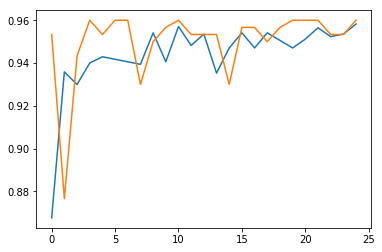

In [39]:
%matplotlib inline 
plt.plot(historia_naszego_treningu.history['acc'], label='training')
plt.plot(historia_naszego_treningu.history['val_acc'], label='validation')
plt.legend()

Pomęczymy teraz sieć trudniejszym zadaniem.
Zobaczmy jak radzi sobie ta sama architektura korzystając z wartości pikseli. Pmiętaj że w przypadku pikseli mamy do czynienia z podobną liczbą wartości co dla własności przetworzonych przez `Xception`. Zobaczycie jednak że przetworzenie przez warstwy splotowe (a więc wyciągnięcie z obrazu własności) ma duże znaczenie. Budujemy taką samą sieć jak wcześniej, inny teraz jest tylko rozmiar danych wejściowych.

In [ ]:
nasza_sieć2 = Sequential()
nasza_sieć2.add(_____(___, activation=____, input_shape=(150 * 150 * 3,)))
nasza_sieć2.add(________________)
nasza_sieć2.add(________________)
nasza_sieć2.add(________________)
nasza_sieć2.add(________________)

Prosimy o `150 * 150 * 3` wartości tzn. jeden ciąg wartości. W związku z tym "rozprostujemy" nasze obrazy tak aby każdy był wektorem wartości:

In [45]:
print('Przed:')
print(X_train.shape)
print(X_test.shape)

X_train = X_train.reshape(1700, -1)
X_test = X_test.reshape(300, -1)

print('Po:')
print(X_train.shape)
print(X_test.shape)

Przed:
(1700, 150, 150, 3)
(300, 150, 150, 3)
Po:
(1700, 67500)
(300, 67500)


In [46]:
nasza_sieć2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
historia_naszego_treningu = nasza_sieć2.fit(
    _______, y_train, epochs=25, validation_data=(______, y_test))

Train on 1700 samples, validate on 300 samples
Epoch 1/25
1700/1700 [==============================] - 24s 14ms/step - loss: 7.2013 - acc: 0.5112 - val_loss: 6.7264 - val_acc: 0.5300
Epoch 2/25
1700/1700 [==============================] - 20s 12ms/step - loss: 6.8533 - acc: 0.5500 - val_loss: 7.4875 - val_acc: 0.5133
Epoch 3/25
1700/1700 [==============================] - 21s 12ms/step - loss: 6.8617 - acc: 0.5529 - val_loss: 6.8118 - val_acc: 0.5633
Epoch 4/25
1700/1700 [==============================] - 21s 12ms/step - loss: 6.9374 - acc: 0.5471 - val_loss: 6.6721 - val_acc: 0.5767
Epoch 5/25
1700/1700 [==============================] - 21s 13ms/step - loss: 6.7330 - acc: 0.5582 - val_loss: 5.9778 - val_acc: 0.6100
Epoch 6/25
1700/1700 [==============================] - 21s 13ms/step - loss: 6.7232 - acc: 0.5629 - val_loss: 6.9300 - val_acc: 0.5467
Epoch 7/25
1700/1700 [==============================] - 22s 13ms/step - loss: 6.6260 - acc: 0.5753 - val_loss: 6.4278 - val_acc: 0.5900
E

Widzimy, że sieć mająca do dyspozycji surowe wartości pikseli radzi sobie dużo gorzej niż taka sama sieć, która uczy się z własności otrzymanych z `Xception`. To znaczy, że te 126 warstw sieci `Xception` jednak robi coś sensownego :)  
Można nawet zaryzykować stwierdzenie, że sieć, która korzysta z surowych pikseli nie uczy się prawie wcale - jej poprawność niewiele różni się od losowej poprawności. Natomiast sieć, która korzystała z własności, a nie pikseli bardzo szybko uczyła się rozróżniać psy i koty na poziomie 96%.  
(dla naszej sieci korzystającej z pikseli moglibyśmy spróbować zmienić *learning rate* albo inne parametry optymalizatora, ale nie otrzymalibyśmy znacząco różniących się wyników niż te powyżej)  
Zobaczmy jeszcze wykres:

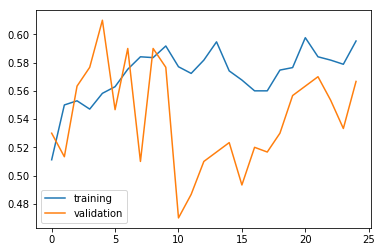

In [48]:
plt.plot(historia_naszego_treningu.history['acc'], label='training')
plt.plot(historia_naszego_treningu.history['val_acc'], label='validation')
plt.legend()

## Podsumowanie
To co zrobiliśmy, czyli wykorzystanie już wytrenowanej sieci do rozwiązania naszego zadania to właśnie *transfer learning*. Zauważ, że użyliśmy do treningu tylko 1700 obrazów, a mimo to uzyskaliśmy znacznie lepszą poprawność niż nasz pierwszy, czy nawet usprawniony model. To właśnie moc *transfer learning'u* - własności, które uczą się wyciągać z obrazu splotowe warstwy sieci stanowią dobrą reprezentację cech obrazu, mają więc zastosowanie również w innych zadaniach z zakresu analizy obrazu.